<a href="https://colab.research.google.com/github/SmrutiRanjan27/Cardiovascular-Risk-Prediction/blob/main/Cardiovascular_Risk_Prediction_Smruti_Ranjan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, roc_curve, auc, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
warnings.filterwarnings('ignore')

In [3]:
file_dir = '/content/drive/MyDrive/AlmaBetter/Cohort Nilgiri/Module 4/Capstone Project/data/'
df = pd.read_csv(file_dir + 'data_cardiovascular_risk.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [5]:
# lets check for distribution of classes
class_0_count, class_1_count = df[df['TenYearCHD']==0].shape[0], df[df['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


There are 17 columns in the dataset. Out of which 15 are attributes/features, column 0 is the id of each sample, and column 16 is the target variable. Before doing some data cleaning and EDA, lets split our dataset into train and test data.<br>

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['TenYearCHD'], random_state = 1)

In [7]:
train_df.shape

(2712, 17)

In [8]:
test_df.shape

(678, 17)

# **Exploratory Data Analysis**
----------------------------------
<br>

## **Categorical Variables**

### **Education**

In [9]:
train_df.education.unique()

array([ 2.,  3.,  1.,  4., nan])

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

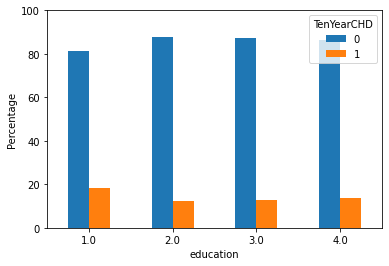

In [10]:
freq_df = train_df.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [11]:
ed_fill = train_df['education'].mode()[0]
print(ed_fill)
train_df['education'] = train_df['education'].fillna(ed_fill)

1.0


In [12]:
prob = 0.99
alpha = 1.0 - prob

In [13]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_df)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [14]:
cat_dependency(freq_df)

significance=0.010, p=0.0004690
Categorical variables are dependent


True

### **Sex**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

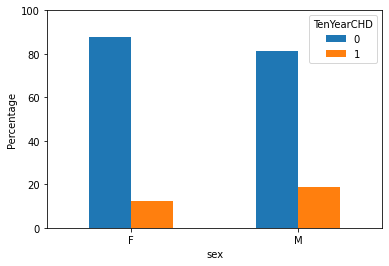

In [15]:
freq_df = train_df.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [16]:
cat_dependency(freq_df)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

**Higher fraction of males are prone to cardiovascular diseases!**

### **Smoking**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

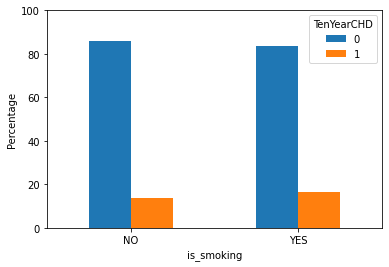

In [17]:
freq_df = train_df.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [18]:
freq_df

TenYearCHD,0,1
is_smoking,,
NO,1177,190
YES,1126,219


In [19]:
cat_dependency(freq_df)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False

**Statistically smoking has no impact on 10-year risk of CHD**

### **BP Meds**

In [20]:
train_df.BPMeds.unique()

array([ 0.,  1., nan])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

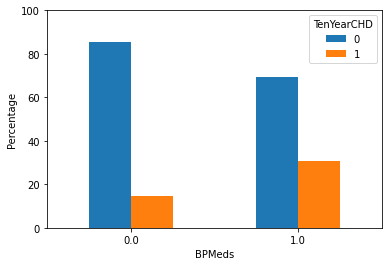

In [21]:
freq_df = train_df.groupby('TenYearCHD')['BPMeds'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [22]:
cat_dependency(freq_df)

significance=0.010, p=0.0001015
Categorical variables are dependent


True

**People who take Blood pressure meds have a higher chance of having CHD**

In [23]:
meds_fill = train_df['BPMeds'].mode()[0]
print(meds_fill)
train_df['BPMeds'] = train_df['BPMeds'].fillna(meds_fill)

0.0


### **Prevalent Stroke**

In [24]:
train_df.prevalentStroke.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

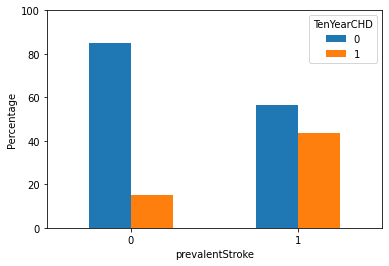

In [25]:
freq_df = train_df.groupby('TenYearCHD')['prevalentStroke'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [26]:
cat_dependency(freq_df)

significance=0.010, p=0.0041885
Categorical variables are dependent


True

**Higher percentage of patients with prevalent stroke symptoms have a 10-year risk of CHD.**

### **Prevalent Hypertension**

In [27]:
train_df.prevalentHyp.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

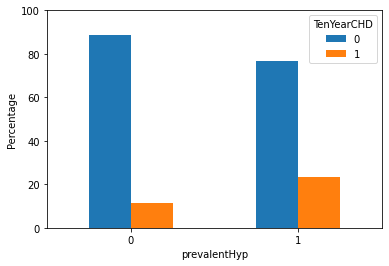

In [28]:
freq_df = train_df.groupby('TenYearCHD')['prevalentHyp'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [29]:
cat_dependency(freq_df)

significance=0.010, p=0.0000000
Categorical variables are dependent


True

**Hypertensive patients are at higher risk of CHD**

### **Diabetes**

In [30]:
train_df.diabetes.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

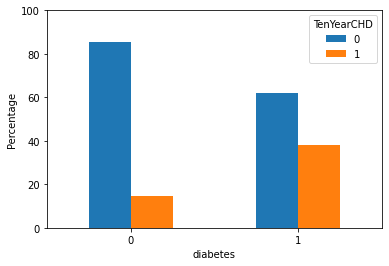

In [31]:
freq_df = train_df.groupby('TenYearCHD')['diabetes'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [32]:
cat_dependency(freq_df)

significance=0.010, p=0.0000004
Categorical variables are dependent


True

**Diabetic patients tend to have a higher 10-year risk of CHD**


## **Continuous Variables**

### **Age**

In [33]:
train_df.age.unique()

array([49, 51, 57, 59, 52, 60, 48, 40, 54, 39, 56, 44, 42, 43, 41, 45, 37,
       61, 53, 62, 47, 36, 55, 34, 46, 64, 38, 58, 63, 35, 50, 65, 67, 66,
       68, 33, 69, 70, 32])

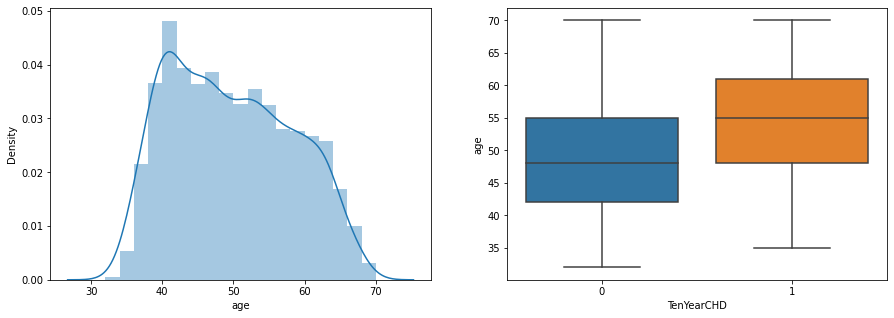

In [34]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['age'], ax=axes[0])
sns.boxplot(y='age',x='TenYearCHD',data=train_df, ax=axes[1])

In [35]:
# using one-way ANOVA test to determine dependency between continuous variables and the target categorical variable
def cont_dependency(feature,alpha=alpha):
  F, p = f_oneway(train_df[train_df['TenYearCHD'] == 1][feature], train_df[train_df['TenYearCHD'] == 0][feature])
  print('significance=%.3f, p=%.5f' % (alpha, p))
  if p <= alpha:
    print('Ten year Risk of CHD is dependent on the continuous variable')
    return True
  else:
    print('Ten year Risk of CHD is not dependent on continuous variable')
    return False

In [36]:
cont_dependency('age')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [37]:
train_df['age_bucket'] = train_df['age'].apply(lambda x : 5*(x//5))

**Bucketing age feature**

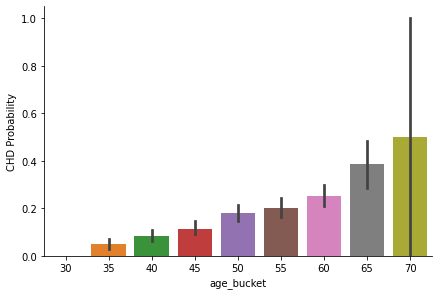

In [38]:
ax=sns.factorplot('age_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**The positive CHD cases seems to be more prevalent in older people.**

### **Cigarrettes per Day**

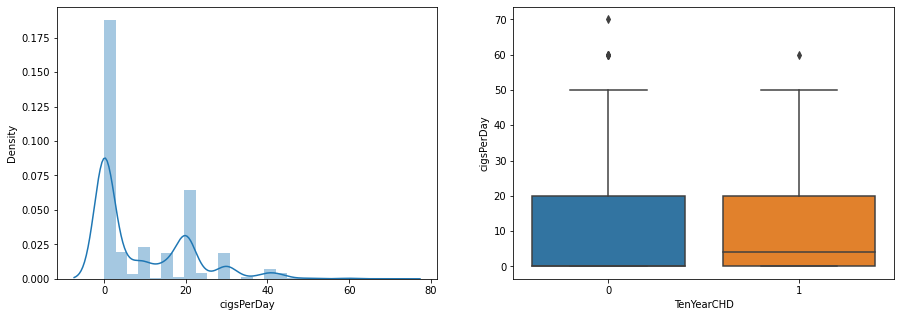

In [39]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['cigsPerDay'], ax=axes[0])
sns.boxplot(y='cigsPerDay',x='TenYearCHD',data=train_df, ax=axes[1])

In [40]:
cig_fill = train_df['cigsPerDay'].median()
print(cig_fill)
train_df['cigsPerDay'] = train_df['cigsPerDay'].fillna(cig_fill)

0.0


In [41]:
cont_dependency('cigsPerDay')

significance=0.010, p=0.00124
Ten year Risk of CHD is dependent on the continuous variable


True

**We see that the median is slighlty higher for the positive cases, which means people who smoke higher number of cigarette per day, tend to show cardio-vascular disease!**

### **Total Cholestrol level**

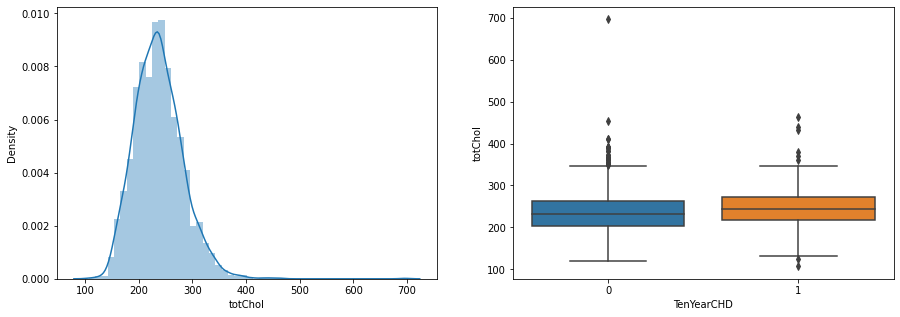

In [42]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [43]:
chol_fill = train_df['totChol'].median()
print(chol_fill)
train_df['totChol'] = train_df['totChol'].fillna(chol_fill)

234.0


In [44]:
#dealing with outliers
vals = train_df.totChol.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['totChol'] = train_df['totChol'].apply(lambda x : x if x > min_lim and x < max_lim else chol_fill)

0.25    206.75
0.75    264.00
Name: totChol, dtype: float64


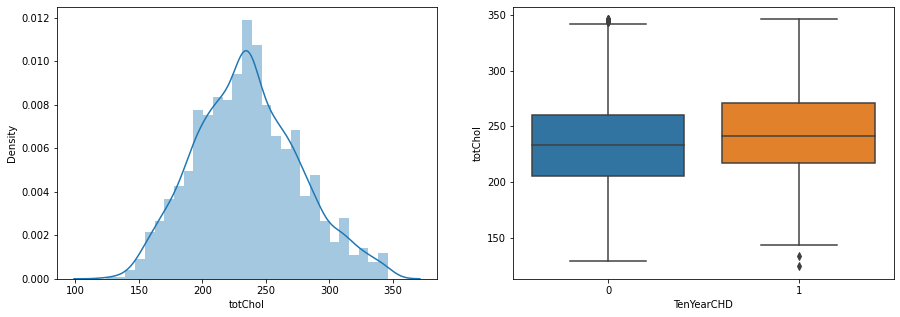

In [45]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [46]:
cont_dependency('totChol')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [47]:
train_df['chol_bucket'] = train_df['totChol'].apply(lambda x : 40*(x//40))

**Bucketing Total cholestrol feature**

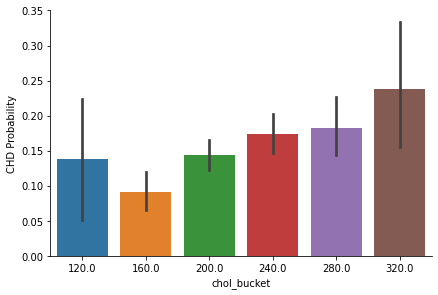

In [48]:
ax = sns.factorplot('chol_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

### **Systolic and diastolic BP**

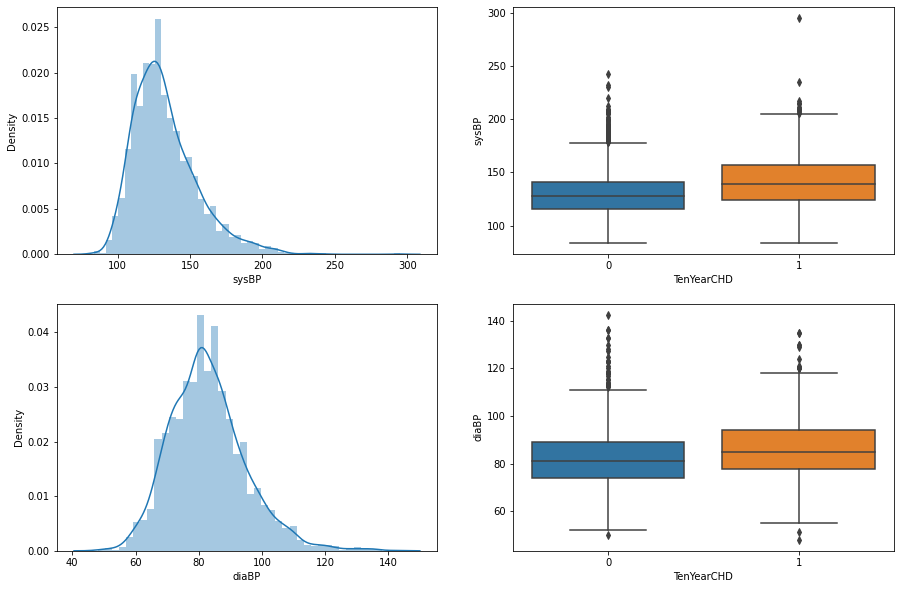

In [49]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.distplot(train_df['sysBP'], ax=axes[0,0])
sns.boxplot(y='sysBP',x='TenYearCHD',data=train_df, ax=axes[0,1])
sns.distplot(train_df['diaBP'], ax=axes[1,0])
sns.boxplot(y='diaBP',x='TenYearCHD',data=train_df, ax=axes[1,1])

In [50]:
#dealing with outliers
vals = train_df.sysBP.quantile([0.25,0.75])
print(vals)
sys_fill = train_df.sysBP.median()
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['sysBP'] = train_df['sysBP'].apply(lambda x : x if x > min_lim and x < max_lim else sys_fill)

0.25    117.0
0.75    144.0
Name: sysBP, dtype: float64


In [51]:
#dealing with outliers
vals = train_df.diaBP.quantile([0.25,0.75])
print(vals)
dia_fill = train_df.diaBP.median()
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['diaBP'] = train_df['diaBP'].apply(lambda x : x if x > min_lim and x < max_lim else dia_fill)

0.25    74.0
0.75    90.0
Name: diaBP, dtype: float64


In [52]:
cont_dependency('sysBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [53]:
cont_dependency('diaBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [54]:
train_df['sysBP_bucket'] = train_df['sysBP'].apply(lambda x : 30*(x//30))

**Bucketing Systolic BP feature**

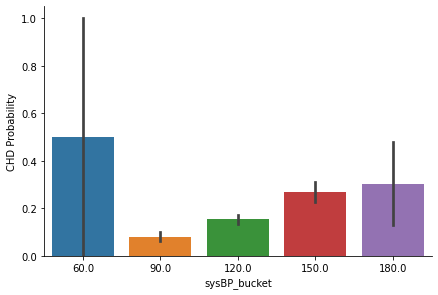

In [55]:
ax = sns.factorplot('sysBP_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**We see a slighlty positive inclination of CHD risk towards high systolic and diastolic Blood pressure.**

### **Body Mass Index (BMI)**

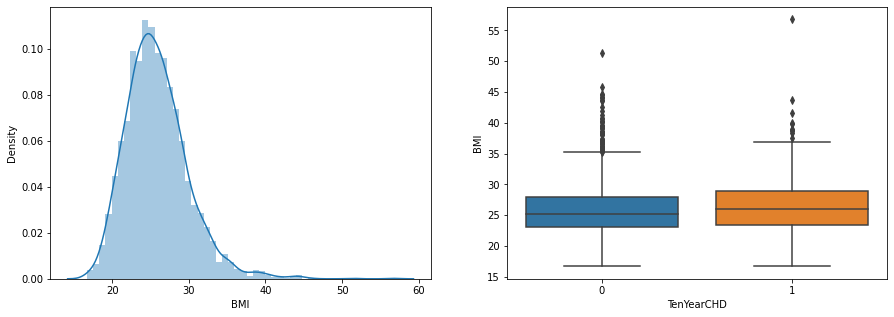

In [56]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['BMI'], ax=axes[0])
sns.boxplot(y='BMI',x='TenYearCHD',data=train_df, ax=axes[1])

In [57]:
bmi_fill = train_df['BMI'].median()
print(bmi_fill)
train_df['BMI'] = train_df['BMI'].fillna(bmi_fill)

25.38


In [58]:
#dealing with outliers
vals = train_df.BMI.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['BMI'] = train_df['BMI'].apply(lambda x : x if x > min_lim and x < max_lim else bmi_fill)

0.25    23.07
0.75    28.06
Name: BMI, dtype: float64


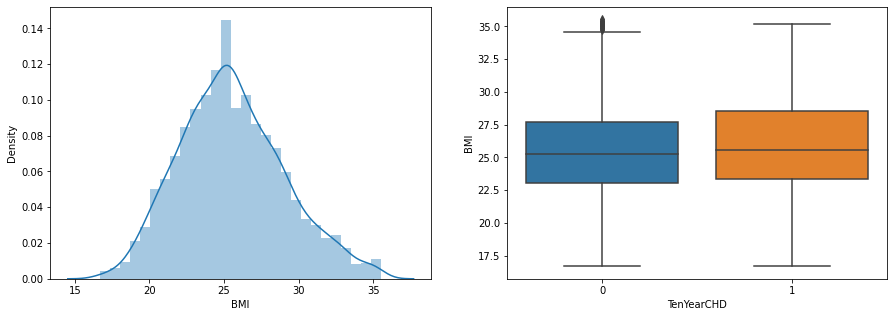

In [59]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['BMI'], ax=axes[0])
sns.boxplot(y='BMI',x='TenYearCHD',data=train_df, ax=axes[1])

In [60]:
cont_dependency('BMI')

significance=0.010, p=0.00668
Ten year Risk of CHD is dependent on the continuous variable


True

In [61]:
train_df['bmi_bucket'] = train_df['BMI'].apply(lambda x : 3*(x//3))

**Bucketing BMI feature**

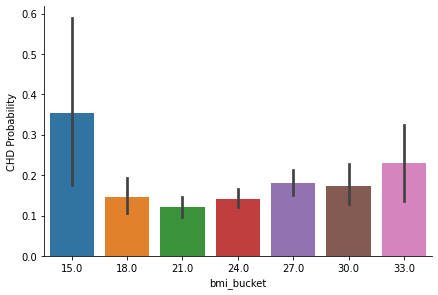

In [62]:
ax = sns.factorplot('bmi_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

### **Heart Rate**

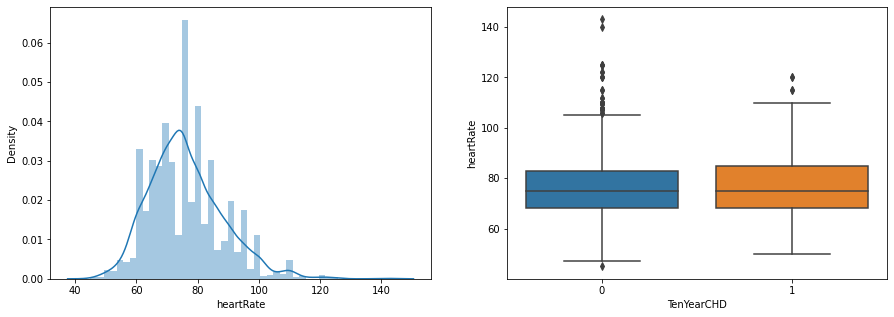

In [63]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['heartRate'], ax=axes[0])
sns.boxplot(y='heartRate',x='TenYearCHD',data=train_df, ax=axes[1])

In [64]:
hr_fill = train_df['heartRate'].median()
print(hr_fill)
train_df['heartRate'] = train_df['heartRate'].fillna(hr_fill)

75.0


In [65]:
cont_dependency('heartRate')

significance=0.010, p=0.17942
Ten year Risk of CHD is not dependent on continuous variable


False

In [66]:
train_df['hr_bucket'] = train_df['heartRate'].apply(lambda x : 10*(x//10))

**Bucketing heart Rate Feature**

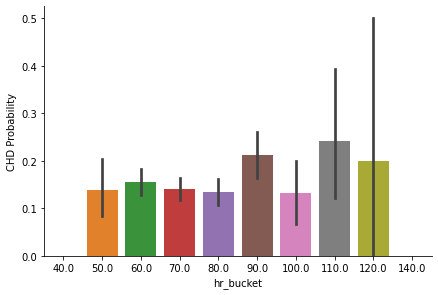

In [67]:
ax = sns.factorplot('hr_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

### **Glucose**

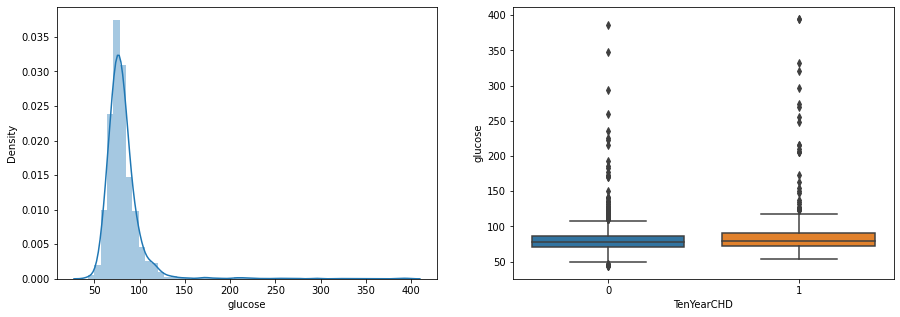

In [68]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['glucose'], ax=axes[0])
sns.boxplot(y='glucose',x='TenYearCHD',data=train_df, ax=axes[1])

In [69]:
glucose_fill = train_df['glucose'].median()
print(glucose_fill)
train_df['glucose'] = train_df['glucose'].fillna(glucose_fill)

78.0


In [70]:
#dealing with outliers
vals = train_df.glucose.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['glucose'] = train_df['glucose'].apply(lambda x : x if x > min_lim and x < max_lim else glucose_fill)

0.25    72.0
0.75    85.0
Name: glucose, dtype: float64


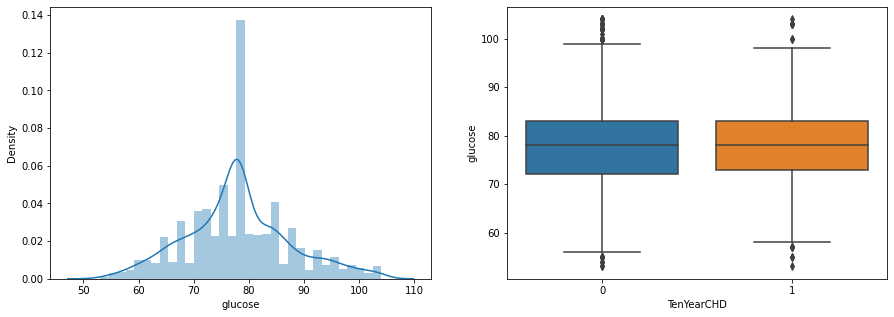

In [71]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['glucose'], ax=axes[0])
sns.boxplot(y='glucose',x='TenYearCHD',data=train_df, ax=axes[1])

In [72]:
cont_dependency('glucose')

significance=0.010, p=0.69895
Ten year Risk of CHD is not dependent on continuous variable


False

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2712 non-null   int64  
 1   age              2712 non-null   int64  
 2   education        2712 non-null   float64
 3   sex              2712 non-null   object 
 4   is_smoking       2712 non-null   object 
 5   cigsPerDay       2712 non-null   float64
 6   BPMeds           2712 non-null   float64
 7   prevalentStroke  2712 non-null   int64  
 8   prevalentHyp     2712 non-null   int64  
 9   diabetes         2712 non-null   int64  
 10  totChol          2712 non-null   float64
 11  sysBP            2712 non-null   float64
 12  diaBP            2712 non-null   float64
 13  BMI              2712 non-null   float64
 14  heartRate        2712 non-null   float64
 15  glucose          2712 non-null   float64
 16  TenYearCHD       2712 non-null   int64  
 17  age_bucket   

# **Dependencies between Independent variables - Check for multicollinearity**

In [74]:
def cat_dependency_matrix(cols, alpha=alpha, verbose=False):
  cat_matrix = np.zeros((cols.shape[0], cols.shape[0]))
  print(cat_matrix.shape)
  for i,col in enumerate(cols):
    for j,col in enumerate(cols):
      if i != j:
        cat_matrix[i,j] = int(cat_dependency(train_df.groupby(cols[j])[cols[i]].value_counts().unstack(0), alpha=alpha, verbose=verbose))
      else:
        cat_matrix[i,j] = 1.
  return pd.DataFrame(cat_matrix, columns=cols, index=cols, dtype=int)

In [75]:
cat_cols = np.array(['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'])
cat_dependency_matrix(cat_cols, alpha=0.01, verbose=False)

(7, 7)


,education,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes
education,1,1,1,0,0,1,1
sex,1,1,1,0,0,0,0
is_smoking,1,1,1,0,0,1,1
BPMeds,0,0,0,1,1,0,1
prevalentStroke,0,0,0,1,1,1,0
prevalentHyp,1,0,1,0,1,1,1
diabetes,1,0,1,1,0,1,1


**Lets look at correlation matrix of categorical variables as well !**

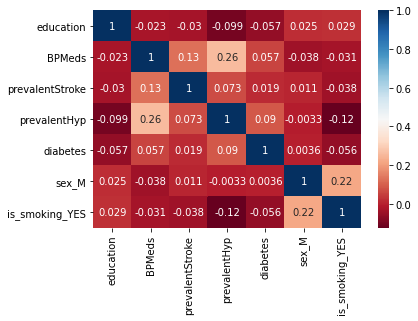

In [76]:
train_cat_df = pd.get_dummies(train_df[cat_cols], drop_first=True) 
sns.heatmap(train_cat_df.corr(), cmap='RdBu', annot=True)

In [77]:
#lets check vif scores
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [78]:
ignore_features = ['education']
train_cat_df_final = train_cat_df[[col for col in train_cat_df.columns if col not in ignore_features]]
calc_vif(train_cat_df_final)

,variables,VIF
0,BPMeds,1.123208
1,prevalentStroke,1.025231
2,prevalentHyp,1.310147
3,diabetes,1.030597
4,sex_M,1.597393
5,is_smoking_YES,1.539392


**Based on the VIF scores, I can safely remove education feature.**

**Lets look at correlation matrix of Continuous variables**

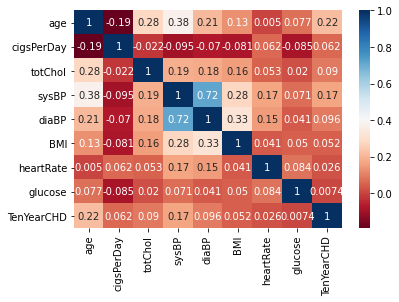

In [79]:
cont_cols = np.array(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'])
sns.heatmap(train_df[cont_cols].corr(), cmap='RdBu', annot=True)

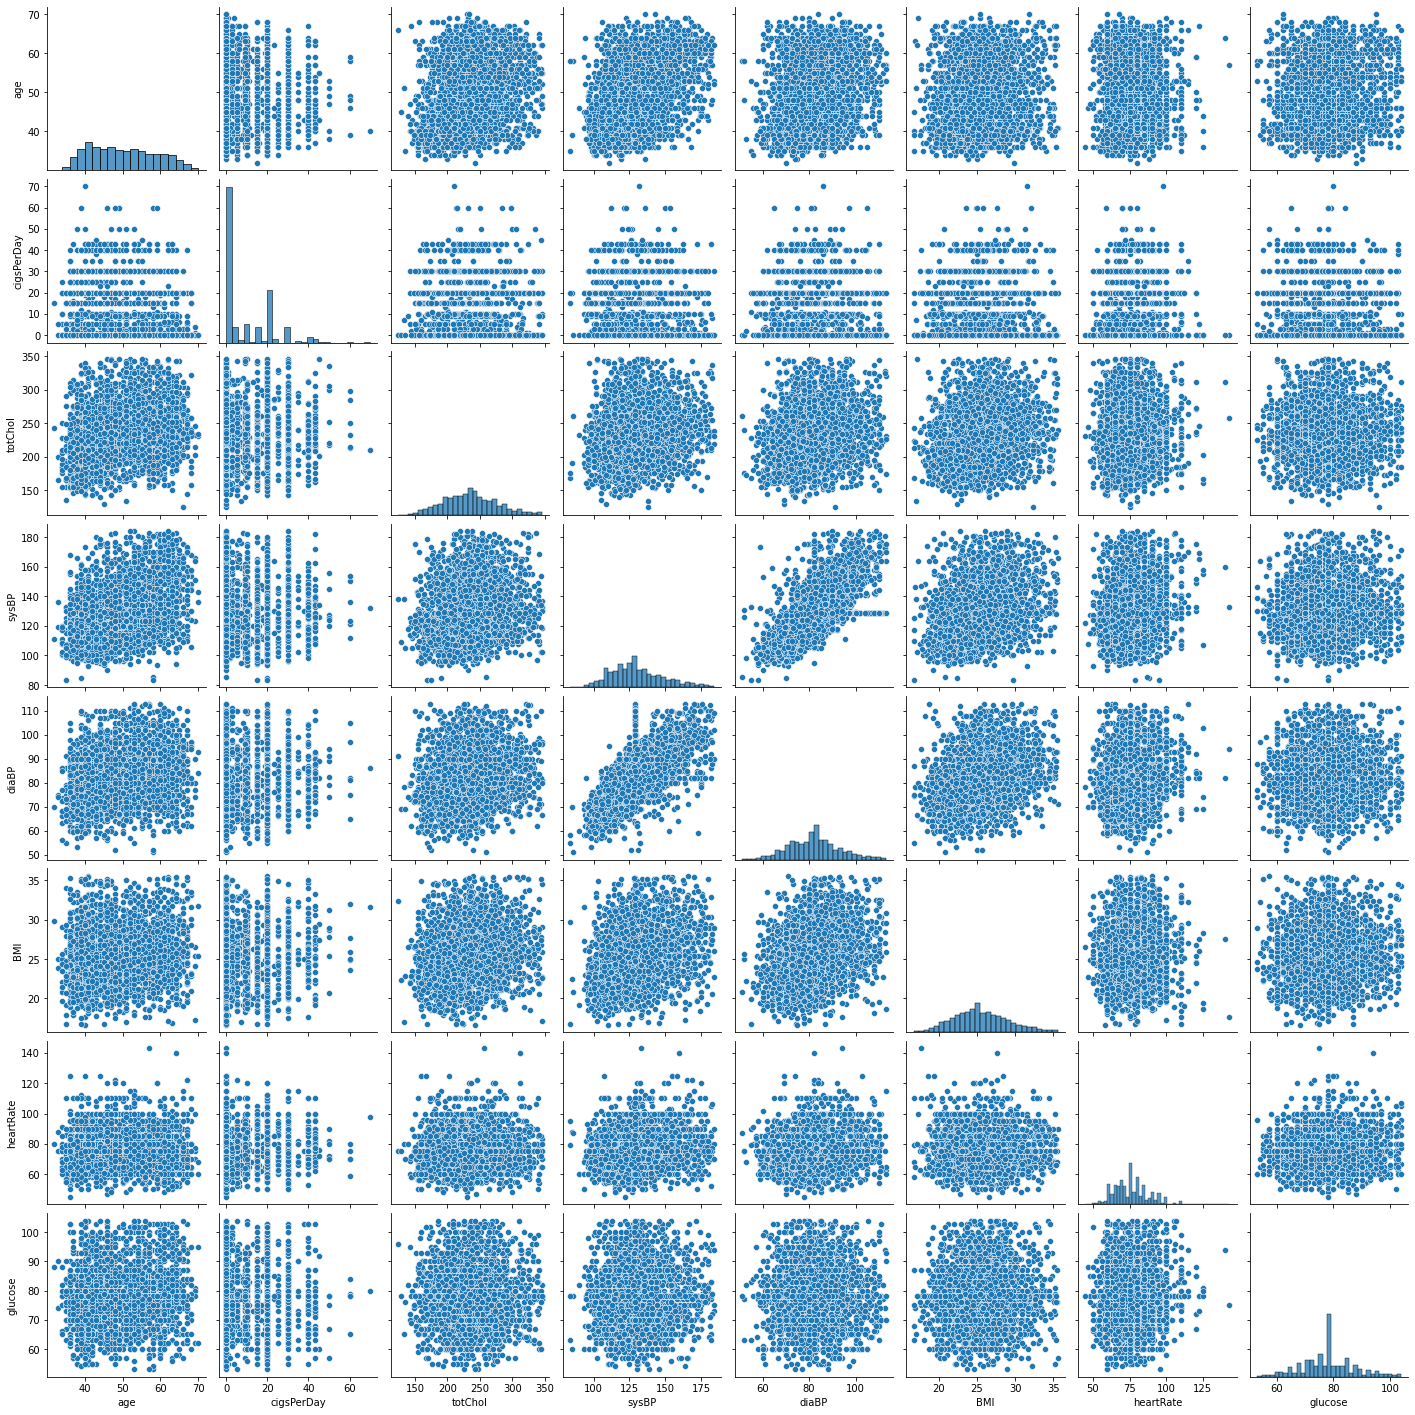

In [80]:
sns.pairplot(train_df[cont_cols[:-1]])

In [81]:
ignore_features = ['TenYearCHD','diaBP']
train_cont_df = train_df[[col for col in cont_cols if col not in ignore_features]]
calc_vif(train_cont_df)

,variables,VIF
0,age,42.178708
1,cigsPerDay,1.610646
2,totChol,36.271855
3,sysBP,63.680042
4,BMI,51.542283
5,heartRate,37.868515
6,glucose,50.633734


**There was a significantly higher correlation between systolic BP and diastolic BP. Based on correlation matrix and VIF scores, I safely remove diabolic BP feature.**

In [82]:
final_train_df = pd.concat((train_cat_df_final, train_cont_df, train_df['TenYearCHD']), axis =1)

**Now we have our final data set with 13 features and one target variable.**

In [83]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BPMeds           2712 non-null   float64
 1   prevalentStroke  2712 non-null   int64  
 2   prevalentHyp     2712 non-null   int64  
 3   diabetes         2712 non-null   int64  
 4   sex_M            2712 non-null   uint8  
 5   is_smoking_YES   2712 non-null   uint8  
 6   age              2712 non-null   int64  
 7   cigsPerDay       2712 non-null   float64
 8   totChol          2712 non-null   float64
 9   sysBP            2712 non-null   float64
 10  BMI              2712 non-null   float64
 11  heartRate        2712 non-null   float64
 12  glucose          2712 non-null   float64
 13  TenYearCHD       2712 non-null   int64  
dtypes: float64(7), int64(5), uint8(2)
memory usage: 360.7 KB


In [84]:
fill_dict = {'education' : ed_fill, 'BPMeds' : meds_fill, 'cigsPerDay' : cig_fill, 'totChol' : chol_fill, 'BMI' : bmi_fill, 'heartRate' : hr_fill, 'glucose' : glucose_fill}

**Preparing our test dataset based on the selected features and the imputed missing values from training dataset.**

In [85]:
final_test_df = test_df
for col in fill_dict.keys():
  final_test_df[col] = final_test_df[col].fillna(fill_dict[col])
final_test_df = pd.get_dummies(final_test_df, drop_first=True)[final_train_df.columns]

In [86]:
X_train, y_train = final_train_df.iloc[:,:-1], final_train_df.iloc[:,-1]
X_test, y_test = final_test_df.iloc[:,:-1], final_test_df.iloc[:,-1]

### **ML Modelling and addressing Class imbalance**

**Over Sampling**

In [87]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

**Logistic Regression**

* **Using the oversampled dataset with Logistic Regression**

In [88]:
lr_model = LogisticRegression().fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))

ROCAUC score: 0.6554330065359477
Recall score: 0.6372549019607843

               precision    recall  f1-score   support

           0       0.91      0.67      0.78       576
           1       0.26      0.64      0.37       102

    accuracy                           0.67       678
   macro avg       0.58      0.66      0.57       678
weighted avg       0.81      0.67      0.71       678



* **Using KFold CV alongwith oversampling**

In [89]:
lr_model = LogisticRegression()
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, valid_index in kf.split(X_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  lr_model.fit(X_ros, y_ros)

lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))

ROCAUC score: 0.6110089869281046
Recall score: 0.5588235294117647

               precision    recall  f1-score   support

           0       0.89      0.66      0.76       576
           1       0.23      0.56      0.32       102

    accuracy                           0.65       678
   macro avg       0.56      0.61      0.54       678
weighted avg       0.79      0.65      0.70       678



In [90]:
print(X_train.columns, '\n', lr_model.coef_)

Index(['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'sex_M',
       'is_smoking_YES', 'age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI',
       'heartRate', 'glucose'],
      dtype='object') 
 [[ 0.12921556  0.05386988  0.87359283  0.90264175  0.33690846  0.08840636
   0.07165264  0.02285507  0.0012068  -0.00378182 -0.04661181 -0.01065733
  -0.01990935]]


**Support Vector Machines**

* **Using the imabalnced dataset in SVC with class_weight='balanced', i.e. penalizing misclassifications in each class approriately !**

In [91]:
# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Recall score:',recall_score(y_test, svc_predict))
print('\n', classification_report(y_test, svc_predict))

ROCAUC score: 0.6815767973856209
Recall score: 0.7450980392156863

               precision    recall  f1-score   support

           0       0.93      0.62      0.74       576
           1       0.26      0.75      0.38       102

    accuracy                           0.64       678
   macro avg       0.59      0.68      0.56       678
weighted avg       0.83      0.64      0.69       678



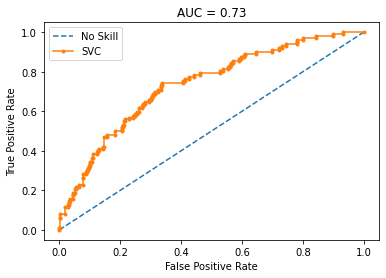

In [92]:
ns_probs = [0 for _ in range(len(y_test))]
svc_probs = svc_model.predict_proba(X_test)
svc_probs = svc_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(svc_fpr, svc_tpr))
plt.legend()
plt.show()

* **Using the oversampled dataset with SVC**

In [93]:
svc_model = SVC(probability=True).fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))

ROCAUC score: 0.6841809640522876
Recall score: 0.7450980392156863

               precision    recall  f1-score   support

           0       0.93      0.62      0.75       576
           1       0.26      0.75      0.38       102

    accuracy                           0.64       678
   macro avg       0.60      0.68      0.57       678
weighted avg       0.83      0.64      0.69       678



* **Using KFold CV alongwith oversampling**

In [94]:
svc_model = SVC(probability=True)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, valid_index in kf.split(X_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  svc_model.fit(X_ros, y_ros)

svc_y_predict = svc_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))

ROCAUC score: 0.6841809640522876
Recall score: 0.7450980392156863

               precision    recall  f1-score   support

           0       0.93      0.62      0.75       576
           1       0.26      0.75      0.38       102

    accuracy                           0.64       678
   macro avg       0.60      0.68      0.57       678
weighted avg       0.83      0.64      0.69       678



* **Using GridSearchCV where scoring metric is recall**

In [95]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [96]:
svc_model = SVC(class_weight='balanced',probability=True)
grid_model = GridSearchCV(svc_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [97]:
grid_model.best_params_

{'C': 1.0}

In [98]:
svc_model = grid_model.best_estimator_

In [99]:
svc_y_predict = svc_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))

ROCAUC score: 0.6815767973856209
Recall score: 0.7450980392156863

               precision    recall  f1-score   support

           0       0.93      0.62      0.74       576
           1       0.26      0.75      0.38       102

    accuracy                           0.64       678
   macro avg       0.59      0.68      0.56       678
weighted avg       0.83      0.64      0.69       678



**XGBoost Classifier**

In [100]:
xgb_model = XGBClassifier(probability=True)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, valid_index in kf.split(X_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  xgb_model.fit(X_ros, y_ros)

xgb_y_predict = xgb_model.predict(X_test.values)

print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))

ROCAUC score: 0.6482843137254902
Recall score: 0.5882352941176471

               precision    recall  f1-score   support

           0       0.91      0.71      0.80       576
           1       0.26      0.59      0.36       102

    accuracy                           0.69       678
   macro avg       0.58      0.65      0.58       678
weighted avg       0.81      0.69      0.73       678

